### Importing Libraries

In [47]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
from lightgbm import LGBMClassifier,plot_importance
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import pickle


### Loading Dataset

In [48]:
df = pd.read_excel("Telecom_Churn.xlsx")
del df['customerID']

In [49]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7027.000000
mean,0.162400,32.412543,65.240234,2312.856755
std,0.368844,24.544475,36.895474,2728.057570
min,0.000000,1.000000,-118.900000,-3329.200000
25%,0.000000,9.000000,35.587500,400.150000
50%,0.000000,29.000000,70.350000,1397.300000
75%,0.000000,55.000000,89.862500,3794.975000
max,1.000000,72.000000,1118.750000,80550.000000


In [50]:
# Missing values
print(df.isnull().sum())
df.dropna(inplace=True)

Gender              5
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        6
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        5
Churn               0
dtype: int64


### Exploratory Data Analysis

In [51]:
# Churn / Non Churn Count vs Gender
def bargraph_plotly(variable):
    churn_counts = df[df['Churn']=='Yes'][variable].value_counts().to_dict()
    df_churn = pd.DataFrame(list(churn_counts.items()), columns = [variable, 'Count'])

    non_churn_counts = df[df['Churn']=='No'][variable].value_counts().to_dict()
    df_non_churn = pd.DataFrame(list(non_churn_counts.items()), columns = [variable, 'Count'])
    trace1 = go.Bar(
                    x = df_churn[variable],
                    y = df_churn.Count,
                    name = "Churn Count",
                    marker_color='#ef553b')
    trace2 = go.Bar(
                x = df_non_churn[variable],
                y = df_non_churn.Count,
                name = "Non-Churn Count", 
                marker_color='#636efa')

    data = [trace1 , trace2]
    layout = go.Layout(barmode = "group",
                    template='plotly_dark',
                    xaxis_title=variable,
                    yaxis_title="Count",
                    title = f"Churn/Non-Churn Count vs {variable}", 
                )

    fig = go.Figure(data = data, layout = layout)
    fig.show()

bargraph_plotly("Gender")


In [52]:
# Churn / Non Churn Count vs Senior Citizen
bargraph_plotly("SeniorCitizen")

In [53]:
# Churn / Non Churn Count vs Tenure

# binning of tenure
df['Tenure Bins'] = pd.cut(df['tenure'], bins = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75], include_lowest=True, labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75'])
bargraph_plotly("Tenure Bins")
del df['Tenure Bins']

In [54]:
# Churn / Non Churn Count vs Phone Service
bargraph_plotly("PhoneService")

In [55]:

bargraph_plotly('PaymentMethod')

In [56]:
# Churn / Non Churn Count vs Contract
bargraph_plotly('Contract')

C:\Users\vedan\AppData\Local\Temp/ipykernel_18036/392333617.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



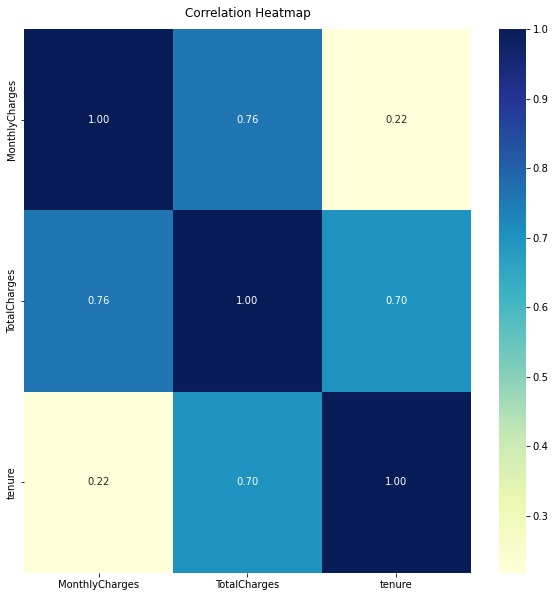

In [57]:
# Correlation in Continuous Variables
def correlation_heatmap(df):
    correlations = df[['MonthlyCharges', 'TotalCharges', 'tenure']].corr()

    fig, ax = plt.subplots(figsize=(10, 10))
    heatmap = sns.heatmap(correlations, annot=True, fmt=".2f", cmap="YlGnBu")
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
    fig.show()

correlation_heatmap(df)



### Data Preprocessing

In [58]:

# No Internet Service / No to 0
df['OnlineSecurity'] = df['OnlineSecurity'].apply(lambda x: 0 if x in ['No', 'No internet service'] else 1)
df['OnlineBackup'] = df['OnlineBackup'].apply(lambda x: 0 if x in ['No', 'No internet service'] else 1)
df['DeviceProtection'] = df['DeviceProtection'].apply(lambda x: 0 if x in ['No', 'No internet service'] else 1)
df['TechSupport'] = df['TechSupport'].apply(lambda x: 0 if x in ['No', 'No internet service'] else 1)
df['StreamingTV'] = df['StreamingTV'].apply(lambda x: 0 if x in ['No', 'No internet service'] else 1)
df['StreamingMovies'] = df['StreamingMovies'].apply(lambda x: 0 if x in ['No', 'No internet service'] else 1)

# No Multiple Lines / No to 0
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: 0 if x in ['No', 'No phone service'] else 1)


# Label Encoding of Categorical variables
le_gender = sk.preprocessing.LabelEncoder().fit(df['Gender'])
le_senior_citizen = sk.preprocessing.LabelEncoder().fit(df['SeniorCitizen'])
le_partner = sk.preprocessing.LabelEncoder().fit(df['Partner'])
le_dependents = sk.preprocessing.LabelEncoder().fit(df['Dependents'])
le_phone_service = sk.preprocessing.LabelEncoder().fit(df['PhoneService'])
le_paperless_billing = sk.preprocessing.LabelEncoder().fit(df['PaperlessBilling'])
le_churn = sk.preprocessing.LabelEncoder().fit(df['Churn'])

df['Gender'] = le_gender.transform(df['Gender'])
df['SeniorCitizen'] = le_senior_citizen.transform(df['SeniorCitizen'])
df['Partner'] = le_partner.transform(df['Partner'])
df['Dependents'] = le_dependents.transform(df['Dependents'])
df['PhoneService'] = le_phone_service.transform(df['PhoneService'])
df['PaperlessBilling'] = le_paperless_billing.transform(df['PaperlessBilling'])
df['Churn'] = le_churn.transform(df['Churn'])


# One Hot Encoding to Categorical variables
df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod', 'InternetService'])
df.sample(10)


,Gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No
2663,1,0,0,1,9,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4425,1,0,0,0,62,1,0,0,1,1,...,1,0,0,1,0,0,0,1,0,0
4095,0,0,1,1,72,1,1,0,0,1,...,0,0,1,1,0,0,0,1,0,0
5550,0,1,1,0,24,1,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2493,0,0,0,0,5,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
6675,1,0,1,0,56,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5914,1,0,1,0,40,1,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
437,0,0,1,1,61,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1933,1,0,1,1,52,0,0,1,0,1,...,0,1,0,1,0,0,0,1,0,0
4962,1,1,1,0,27,1,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [59]:
# Standard Scaling of Continuous Variables
scaler = sk.preprocessing.StandardScaler()
scaler = scaler.fit(df[['MonthlyCharges', 'tenure']])
df[['MonthlyCharges', 'tenure']] = scaler.transform(df[['MonthlyCharges', 'tenure']])
df.sample(10)


,Gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No
6648,0,0,1,0,0.879969,1,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2591,1,0,1,1,-0.220135,1,0,1,1,0,...,1,0,0,0,1,0,0,1,0,0
4160,1,0,0,0,1.491138,1,1,1,1,1,...,0,1,0,0,1,0,0,1,0,0
3944,0,0,0,0,-1.198005,1,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
6257,1,0,1,1,0.228056,1,1,0,0,1,...,1,0,0,0,1,0,0,0,1,0
3956,0,1,0,0,-0.709070,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
5837,1,1,0,0,-0.546091,1,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
1600,0,1,0,0,-1.116515,0,0,0,1,0,...,1,0,0,0,0,1,0,1,0,0
6211,1,0,0,0,-0.423857,1,1,0,1,0,...,1,0,0,0,0,1,0,0,1,0
3857,0,0,1,1,0.350290,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


### Feature Selection

In [60]:
#Correlation between Churn and Continuous Variables (Point Biseral Correlation)
def churn_continous_corr(variable):
    print(f"Point Biseral Correlation between Churn and {variable} is {stats.pointbiserialr(df['Churn'], df[variable])[0]}")

churn_continous_corr('MonthlyCharges')
churn_continous_corr('TotalCharges')
churn_continous_corr('tenure')


Point Biseral Correlation between Churn and MonthlyCharges is 0.15141056586048882
Point Biseral Correlation between Churn and TotalCharges is -0.17289854041162947
Point Biseral Correlation between Churn and tenure is -0.35458531388677794


In [61]:
# Variation Inflation Factor for Multicollinearity Check
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False).reset_index(drop=True)

vif_cal(input_data=df, dependent_col="Churn")

C:\Users\vedan\AppData\Local\Temp/ipykernel_18036/252887264.py:10: RuntimeWarning:

divide by zero encountered in double_scalars



,Var,Vif
0,InternetService_No,inf
1,InternetService_DSL,inf
2,PaymentMethod_Electronic check,inf
3,PaymentMethod_Credit card (automatic),inf
4,PaymentMethod_Bank transfer (automatic),inf
5,Contract_Two year,inf
6,Contract_One year,inf
7,Contract_Month-to-month,inf
8,InternetService_Fiber optic,inf
9,PaymentMethod_Mailed check,inf


### Model Building

In [62]:
# Class Imbalance
df['Churn'].value_counts()

0    5152
1    1864
Name: Churn, dtype: int64

In [63]:
# Oversampling using SMOTE
X = df.drop(['Churn', 'TotalCharges'], axis=1)
y = df['Churn']

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [64]:
# Class Imbalance after Oversampling
y_sm.value_counts()

0    5152
1    5152
Name: Churn, dtype: int64

In [65]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)


In [66]:
# Light GBM
classifier = LGBMClassifier(n_estimators=150,learning_rate=0.11,
                      min_child_samples=30,num_leaves=60)
classifier.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.11, min_child_samples=30, n_estimators=150,
               num_leaves=60)

### Model Evaluation

Precision : 82.02038924930491
 Recall: 86.42578125
 F1 Score: 84.1654778887304
 Accuracy: 83.84279475982532



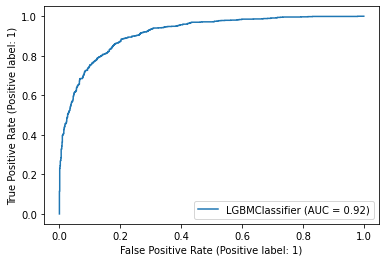

In [67]:
from sklearn.metrics import confusion_matrix, plot_roc_curve, accuracy_score, precision_score, recall_score, f1_score

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
plot_roc_curve(classifier, X_test, y_test) 

print(f"Precision : {precision*100}\n Recall: {recall*100}\n F1 Score: {f1_score*100}\n Accuracy: {accuracy*100}\n")


# Dumping Model in the Pickle File
with open('classifier.pkl', 'wb') as classifier_pkl:
    pickle.dump(classifier, classifier_pkl)


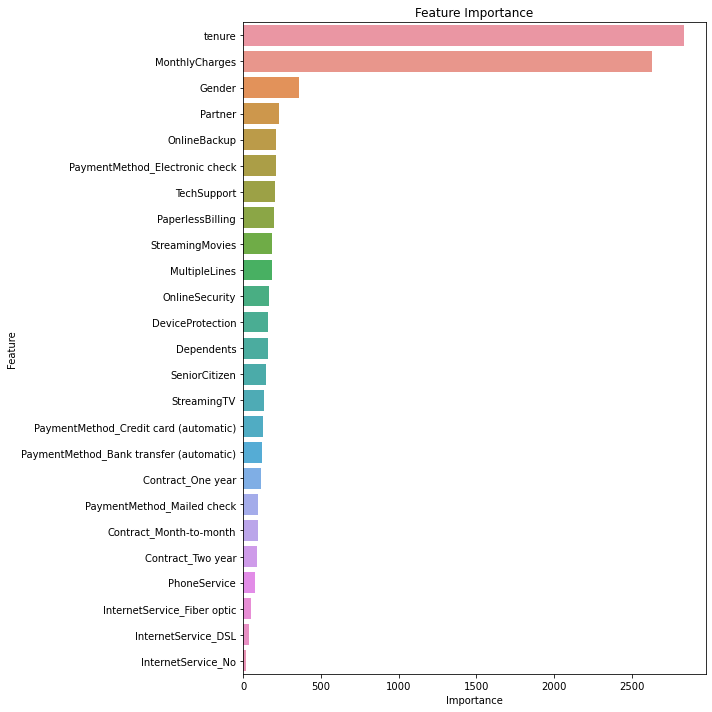

In [68]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': classifier.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [69]:
# Exporting the Standard Scaler, Label Encoder
with open('scaler.pkl', 'wb') as scaler_pkl:
    pickle.dump(scaler, scaler_pkl)

le = {
    'Gender': le_gender, 
    'SeniorCitizen': le_senior_citizen,
    'Partner': le_partner,
    'Dependents': le_dependents,
    'PhoneService': le_phone_service,
    'PaperlessBilling': le_paperless_billing
}
with open('label_encoder.pkl', 'wb') as le_pkl:
    pickle.dump(le, le_pkl)

In [74]:
for i in X_train.columns:
    print(i)

Gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
PaperlessBilling
MonthlyCharges
Contract_Month-to-month
Contract_One year
Contract_Two year
PaymentMethod_Bank transfer (automatic)
PaymentMethod_Credit card (automatic)
PaymentMethod_Electronic check
PaymentMethod_Mailed check
InternetService_DSL
InternetService_Fiber optic
InternetService_No
